<a href="https://colab.research.google.com/github/Winkielek/gflownet/blob/trajectories-analysis/notebooks/mols_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Clone gflownet lib
!rm -rf gflownet
!git clone https://github.com/Winkielek/gflownet.git

# Freeze torch version
!pip install torch==2.1.0+cu121 -f https://download.pytorch.org/whl/torch_stable.html

# Install torch geometric
!pip install torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-2.1.0+cu121.html
!pip install torch-geometric scipy==1.8 deepchem

# Install gflownet lib
!pip install -e ./gflownet

Cloning into 'gflownet'...
remote: Enumerating objects: 1370, done.
remote: Counting objects: 100% (494/494), done.
remote: Compressing objects: 100% (157/157), done.
remote: Total 1370 (delta 386), reused 353 (delta 336), pack-reused 876
Receiving objects: 100% (1370/1370), 12.74 MiB | 3.27 MiB/s, done.
Resolving deltas: 100% (763/763), done.
Looking in links: https://download.pytorch.org/whl/torch_stable.html
Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 47.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 52.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.2/693.2 kB 53.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 51.9 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Fo

In [23]:
import os
import shutil
import socket
from typing import Callable, Dict, List, Tuple, Union

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch_geometric.data as gd
from rdkit import Chem
from rdkit.Chem.rdchem import Mol as RDMol
from torch import Tensor
from torch.utils.data import Dataset

from gflownet.config import Config
from gflownet.envs.frag_mol_env import FragMolBuildingEnvContext, Graph
from gflownet.models import bengio2021flow
from gflownet.online_trainer import StandardOnlineTrainer
from gflownet.trainer import FlatRewards, GFNTask, RewardScalar
from gflownet.utils.conditioning import TemperatureConditional

import matplotlib.pyplot as plt
import networkx as nx
import deepchem as dc

In [2]:
class SEHTask(GFNTask):
    """Sets up a task where the reward is computed using a proxy for the binding energy of a molecule to
    Soluble Epoxide Hydrolases.

    The proxy is pretrained, and obtained from the original GFlowNet paper, see `gflownet.models.bengio2021flow`.

    This setup essentially reproduces the results of the Trajectory Balance paper when using the TB
    objective, or of the original paper when using Flow Matching.
    """

    def __init__(
        self,
        dataset: Dataset,
        cfg: Config,
        rng: np.random.Generator = None,
        wrap_model: Callable[[nn.Module], nn.Module] = None,
    ):
        self._wrap_model = wrap_model
        self.rng = rng
        self.models = self._load_task_models()
        self.dataset = dataset
        self.temperature_conditional = TemperatureConditional(cfg, rng)
        self.num_cond_dim = self.temperature_conditional.encoding_size()

    def flat_reward_transform(self, y: Union[float, Tensor]) -> FlatRewards:
        return FlatRewards(torch.as_tensor(y) / 8)

    def inverse_flat_reward_transform(self, rp):
        return rp * 8

    def _load_task_models(self):
        model = bengio2021flow.load_original_model()
        model, self.device = self._wrap_model(model, send_to_device=True)
        return {"seh": model}

    def sample_conditional_information(self, n: int, train_it: int) -> Dict[str, Tensor]:
        return self.temperature_conditional.sample(n)

    def cond_info_to_logreward(self, cond_info: Dict[str, Tensor], flat_reward: FlatRewards) -> RewardScalar:
        return RewardScalar(self.temperature_conditional.transform(cond_info, flat_reward))

    def compute_flat_rewards(self, mols: List[RDMol]) -> Tuple[FlatRewards, Tensor]:
        graphs = [bengio2021flow.mol2graph(i) for i in mols]
        is_valid = torch.tensor([i is not None for i in graphs]).bool()
        if not is_valid.any():
            return FlatRewards(torch.zeros((0, 1))), is_valid
        batch = gd.Batch.from_data_list([i for i in graphs if i is not None])
        batch.to(self.device)
        preds = self.models["seh"](batch).reshape((-1,)).data.cpu()
        preds[preds.isnan()] = 0
        preds = self.flat_reward_transform(preds).clip(1e-4, 100).reshape((-1, 1))
        return FlatRewards(preds), is_valid


SOME_MOLS = [
    "O=C(NCc1cc(CCc2cccc(N3CCC(c4cc(-c5cc(-c6cncnc6)[nH]n5)ccn4)CC3)c2)ccn1)c1cccc2ccccc12",
    "O=c1nc2[nH]c3cc(-c4cc(C5CC(c6ccc(CNC7CCOC7c7csc(C8=CC(c9ccc%10ccccc%10c9)CCC8)n7)cc6)CO5)c[nH]4)ccc3nc-2c(=O)[nH]1",
    "c1ccc(-c2cnn(-c3cc(-c4cc(CCc5cc(C6CCC(c7cc(-c8ccccc8)[nH]n7)CO6)ncn5)n[nH]4)ccn3)c2)cc1",
    "O=C(NCc1cc(C2CCNC2C2CCNC2)ncn1)c1cccc(-c2cccc(-c3cccc(C4CCC(c5ccccc5)CO4)c3)c2)c1",
    "O=C(NCc1cccc(C2COC(c3ccc4nc5c(=O)[nH]c(=O)nc-5[nH]c4c3)C2)c1)c1cccc(CCc2cccc(-c3ncnc4c3ncn4C3CCCN3)c2)c1",
    "O=C(NCc1ccc(OCc2ccc(-c3ccncc3C3CCNCC3)cn2)cc1)c1cccc(N2CCC(C3CCCN3)CC2)n1",
    "O=C(NCc1ccc(C2CCC(c3cccc(-c4cccc(C5CCOC5)c4)c3)CO2)cn1)c1ccc(-n2ccc(-c3ccc4nc5c(=O)[nH]c(=O)nc-5[nH]c4c3)n2)cn1",
    "O=C(NCc1nc2c(c(=O)[nH]1)NC(c1cn(N3CCN(c4ccc5nc6c(=O)[nH]c(=O)nc-6[nH]c5c4)CC3)c(=O)[nH]c1=O)CN2)c1ccc[n+](-c2cccc(-c3nccc(-c4ccccc4)n3)c2)c1",
    "C1=C(C2CCC(c3ccnc(-c4ccc(CNC5CCC(c6ccncc6)OC5)cc4)n3)CO2)CCC(c2cc(-c3cncnc3)c3ccccc3c2)C1",
    "O=C(NCc1cccc(-c2nccc(-c3cc(-c4ccc5ccccc5c4)n[nH]3)n2)c1)C1CCC(C2CCC(c3cn(-c4ccc5nc6c(=O)[nH]c(=O)nc-6[nH]c5c4)c(=O)[nH]c3=O)OC2)O1",
    "O=C(Nc1ccc2ccccc2c1)c1cccc(-c2cccc(CNN3CCN(C4CCCC(c5cccc(C6CCCN6)c5)C4)CC3)c2)c1",
    "O=C(NCC1CC=C(c2cc(CCc3c[nH]c(-c4cccc(-c5ccccc5)c4)c3)n[nH]2)CC1)c1cccc(C2CCNC2)n1",
    "O=C(Nc1nccc(CNc2cc(C3CCNC3)n[nH]2)n1)c1nccc(C2CCC(C3CCNCC3c3ccc4ccccc4c3)CO2)n1",
    "C1=C(C2CCC(c3ccc(-c4cc(C5CCCNC5)n[nH]4)cc3)OC2)CCCC1CCc1cccc(-c2cccc(-c3ncnc4[nH]cnc34)c2)n1",
    "O=C(NCc1cc(C2CCC(C3CCN(c4cc(-c5nccc(-c6cccc(-c7ccccc7)c6)n5)c[nH]4)CC3)CO2)ccn1)c1ccccc1",
    "O=C(NCc1cccc(-c2ccn(NCc3ccc(-c4cc(C5CNC(c6ccncc6)C5)c[nH]4)cc3)n2)c1)c1ccc2ccccc2c1",
    "O=c1nc2n(-c3cccc(OCc4cccc(CNC5CCC(c6cccc(-c7ccc(C8CCNC8)cc7)c6)OC5)c4)n3)c3ccccc3nc-2c(=O)[nH]1",
    "O=C(NCc1ccc(C2OCCC2C2CC(c3ccnc(-c4ccc5ccccc5c4)c3)CO2)cc1)c1nccc(N2C=CCC(c3ccccc3)=C2)n1",
    "O=C(NCNC(=O)c1cccc(C(=O)NCc2cccc(-c3ccc4[nH]c5nc(=O)[nH]c(=O)c-5nc4c3)c2)n1)c1ccnc(-c2nccc(C3CCCN3)n2)c1",
    "O=c1nc2[nH]c3cc(C4CCC(c5ccc(-c6cc(C7CCC(C8CCCC(C9CCC(c%10ccc(-c%11cncnc%11)cc%10)O9)O8)OC7)ccn6)cn5)CO4)ccc3nc-2c(=O)[nH]1",
    "O=c1[nH]c(CNc2cc(-c3cccc(-n4ccc(-c5ccc6ccccc6c5)n4)c3)c[nH]2)nc2c1NC(n1ccc(C3CCC(c4cccnc4)CO3)n1)CN2",
    "O=c1nc2[nH]c3cc(C=CC4COC(C5CCCC(C6CCOC(C7CCC(c8cccc(-c9ccnc(-c%10ccc%11ccccc%11c%10)n9)c8)CO7)C6)O5)C4)ccc3nc-2c(=O)[nH]1",
    "c1ccc2c(C3CC(CNc4ccnc(C5CCNC5)c4)CO3)cc(NCc3ccc(-c4cc(C5CCNC5)c[nH]4)cc3)cc2c1",
    "O=C(NCc1nccc(C2CC(C(=O)NC3CCC(c4ccc5nc6c(=O)[nH]c(=O)nc-6[nH]c5c4)CO3)CCO2)n1)c1ccnc(-n2cc(-n3cnc4cncnc43)cn2)n1",
    "O=C(NCc1ccc(-c2ccccc2)cc1)c1cccc(C(=O)NCc2nccc(N3C=CCC(c4ncnc5c4ncn5-c4cccc5ccccc45)=C3)n2)c1",
]


class LittleSEHDataset(Dataset):
    """Note: this dataset isn't used by default, but turning it on showcases some features of this codebase.

    To turn on, self `cfg.algo.offline_ratio > 0`"""

    def __init__(self) -> None:
        super().__init__()
        self.props: List[Tensor] = []
        self.mols: List[Graph] = []

    def setup(self, task, ctx):
        rdmols = [Chem.MolFromSmiles(i) for i in SOME_MOLS]
        self.mols = [ctx.mol_to_graph(i) for i in rdmols]
        self.props = task.compute_flat_rewards(rdmols)[0]

    def __len__(self):
        return len(self.mols)

    def __getitem__(self, index):
        return self.mols[index], self.props[index]


class SEHFragTrainer(StandardOnlineTrainer):
    task: SEHTask
    training_data: LittleSEHDataset

    def set_default_hps(self, cfg: Config):
        cfg.hostname = socket.gethostname()
        cfg.pickle_mp_messages = False
        cfg.num_workers = 8
        cfg.opt.learning_rate = 1e-4
        cfg.opt.weight_decay = 1e-8
        cfg.opt.momentum = 0.9
        cfg.opt.adam_eps = 1e-8
        cfg.opt.lr_decay = 20_000
        cfg.opt.clip_grad_type = "norm"
        cfg.opt.clip_grad_param = 10
        cfg.algo.global_batch_size = 64
        cfg.algo.offline_ratio = 0
        cfg.model.num_emb = 128
        cfg.model.num_layers = 4

        cfg.algo.method = "TB"
        cfg.algo.max_nodes = 9
        cfg.algo.sampling_tau = 0.9
        cfg.algo.illegal_action_logreward = -75
        cfg.algo.train_random_action_prob = 0.0
        cfg.algo.valid_random_action_prob = 0.0
        cfg.algo.valid_offline_ratio = 0
        cfg.algo.tb.epsilon = None
        cfg.algo.tb.bootstrap_own_reward = False
        cfg.algo.tb.Z_learning_rate = 1e-3
        cfg.algo.tb.Z_lr_decay = 50_000
        cfg.algo.tb.do_parameterize_p_b = False
        cfg.algo.tb.do_sample_p_b = True

        cfg.replay.use = False
        cfg.replay.capacity = 10_000
        cfg.replay.warmup = 1_000

    def setup_task(self):
        self.task = SEHTask(
            dataset=self.training_data,
            cfg=self.cfg,
            rng=self.rng,
            wrap_model=self._wrap_for_mp,
        )

    def setup_data(self):
        super().setup_data()
        self.training_data = LittleSEHDataset()

    def setup_env_context(self):
        self.ctx = FragMolBuildingEnvContext(max_frags=self.cfg.algo.max_nodes, num_cond_dim=self.task.num_cond_dim)

    def setup(self):
        super().setup()
        self.training_data.setup(self.task, self.ctx)


In [3]:
if __name__ == "__main__":

    hps = {
        "log_dir": "./logs/debug_run_seh_frag_pb",
        "device": "cuda" if torch.cuda.is_available() else "cpu",
        "overwrite_existing_exp": True,
        "num_training_steps": 500,
        "num_workers": 2,
        "opt": {
            "lr_decay": 20000,
        },
        "algo": {"sampling_tau": 0.99, "offline_ratio": 0.0},
        "cond": {
            "temperature": {
                "sample_dist": "uniform",
                "dist_params": [0, 64.0],
            }
        },
    }
    if os.path.exists(hps["log_dir"]):
        if hps["overwrite_existing_exp"]:
            shutil.rmtree(hps["log_dir"])
        else:
            raise ValueError(f"Log dir {hps['log_dir']} already exists. Set overwrite_existing_exp=True to delete it.")
    os.makedirs(hps["log_dir"])

    trial = SEHFragTrainer(hps)
    trial.print_every = 100
    # trial.run()



Hyperparameters:

log_dir: ./logs/debug_run_seh_frag_pb
device: cuda
seed: 0
validate_every: 1000
checkpoint_every: null
print_every: 100
start_at_step: 0
num_final_gen_steps: null
num_training_steps: 500
num_workers: 2
hostname: 0eca7ebd1862
pickle_mp_messages: false
git_hash: 9ce40a1
overwrite_existing_exp: true
algo:
  method: TB
  global_batch_size: 64
  max_len: 128
  max_nodes: 9
  max_edges: 128
  illegal_action_logreward: -75.0
  offline_ratio: 0.0
  valid_offline_ratio: 0.0
  train_random_action_prob: 0.0
  valid_random_action_prob: 0.0
  valid_sample_cond_info: true
  sampling_tau: 0.99
  tb:
    bootstrap_own_reward: false
    epsilon: null
    reward_loss_multiplier: 1.0
    variant: TB
    do_correct_idempotent: false
    do_parameterize_p_b: false
    do_sample_p_b: true
    do_length_normalize: false
    subtb_max_len: 128
    Z_learning_rate: 0.001
    Z_lr_decay: 50000.0
    cum_subtb: true
  moql:
    gamma: 1.0
    num_omega_samples: 32
    num_objectives: 2
    la

In [4]:
PATH = "./model"

In [5]:
# torch.save(trial.model.state_dict(), PATH)

In [6]:
model = trial.model
model.load_state_dict(torch.load(PATH))
model = model.to("cuda")

In [78]:
n = 1000
batch_size = 100
num_gen = 0

traj = []
rew = []

while num_gen<n:

    pred = trial.algo.graph_sampler.sample_from_model(
    model,
    batch_size,
    trial.task.sample_conditional_information(batch_size,None)["encoding"].to("cuda"),
    "cuda"
    )

    # Store trajectories
    for p in pred:
        traj.append(p["traj"])
    # Store rewards
    mols = [trial.ctx.graph_to_mol(p["result"])for p in pred]
    rewards = trial.task.compute_flat_rewards(mols)
    rewards = rewards[0].numpy().reshape(-1).tolist()
    rew += rewards
    num_gen += batch_size

In [79]:
# Inverse transformation of rewards
rew = [8*r for r in rew]

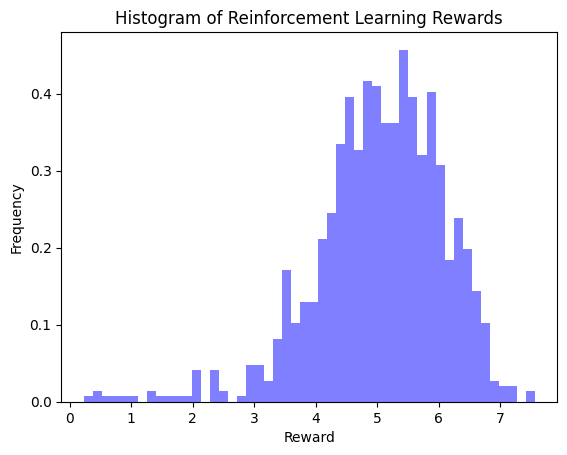

In [80]:
# Create a histogram
plt.hist(rew, bins=50, density=True, alpha=0.5, color='blue')

# Add labels and title
plt.xlabel('Reward')
plt.ylabel('Frequency')
plt.title('Histogram of Reinforcement Learning Rewards')

# Show the plot
plt.show()

In [81]:
# How does a step of trajectory look like?
traj_id = 10
state = 4
print(traj[traj_id][state])
print(f"Current graph: {traj[traj_id][state][0]}")
cur_action = traj[traj_id][state][1]
print(f"Current action: {cur_action}")
print(f"Action source: {cur_action.source}")
print(f"Action target: {cur_action.target}")
print(f"Action value: {cur_action.value}")

(<[0, 1, 2, 3], [(0, 1), (0, 2), (1, 3)], [4, 11, 67, 65]>, <GraphActionType.AddNode, 2, 9>)
Current graph: <[0, 1, 2, 3], [(0, 1), (0, 2), (1, 3)], [4, 11, 67, 65]>
Current action: <GraphActionType.AddNode, 2, 9>
Action source: 2
Action target: None
Action value: 9


C1=CNC=CC1
C1CCOCC1
c1ccsc1
c1ccccc1
Next fragment added: C1CCNCC1


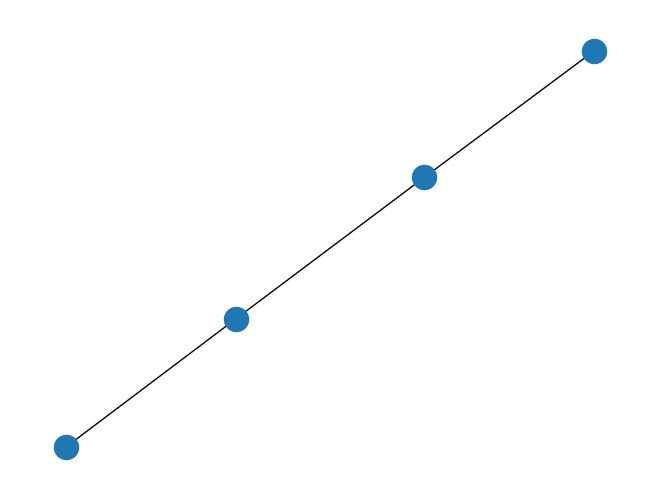

In [82]:
# How does nodes translate to fragments?
g = traj[traj_id][state][0]
for i in g.nodes:
    mol = trial.ctx.frags_mol[g.nodes[i]["v"]]
    mol_smi = trial.ctx.frags_smi[g.nodes[i]["v"]]
    print(mol_smi)
print(f"Next fragment added: {trial.ctx.frags_smi[cur_action.value]}")
nx.draw(g)

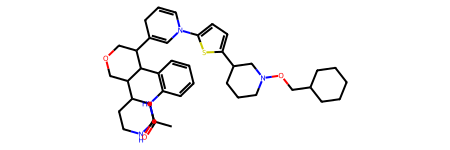

In [83]:
# Output molecule
trial.ctx.graph_to_mol(traj[traj_id][-1][0])

### Trajectories to graphs and molecules

In [84]:
# Keep only graphs from trajectories
graphs = []

for t in traj:
    cur_act = []
    for step in t:
        cur_act.append(step[0])
    graphs.append(cur_act)

In [85]:
def graph_to_mol(trial_ctx, g: Graph) -> Chem.Mol:
    """Convert a Graph to an RDKit molecule

    Parameters
    ----------
    g: Graph
        A Graph instance representing a fragment junction tree.

    Returns
    -------
    m: Chem.Mol
        The corresponding RDKit molecule
    """
    offsets = np.cumsum([0] + [trial_ctx.frags_numatm[g.nodes[i]["v"]] for i in g])
    mol = None
    for i in g.nodes:
        if mol is None:
            mol = trial_ctx.frags_mol[g.nodes[i]["v"]]
        else:
            mol = Chem.CombineMols(mol, trial_ctx.frags_mol[g.nodes[i]["v"]])

    mol = Chem.EditableMol(mol)
    bond_atoms = []
    for a, b in g.edges:
        afrag = g.nodes[a]["v"]
        bfrag = g.nodes[b]["v"]
        # if self.fail_on_missing_attr:
        #     assert "src_attach" in g.edges[(a, b)] and "dst_attach" in g.edges[(a, b)]
        u, v = (
            int(trial_ctx.frags_stems[afrag][g.edges[(a, b)].get("src_attach", 0)] + offsets[a]),
            int(trial_ctx.frags_stems[bfrag][g.edges[(a, b)].get("dst_attach", 0)] + offsets[b]),
        )
        bond_atoms += [u, v]
        mol.AddBond(u, v, Chem.BondType.SINGLE)
    mol = mol.GetMol()
    def _pop_H(atom):
        atom = mol.GetAtomWithIdx(atom)
        nh = atom.GetNumExplicitHs()
        if nh > 0:
            atom.SetNumExplicitHs(nh - 1)

    list(map(_pop_H, bond_atoms))
    Chem.SanitizeMol(mol)
    return mol

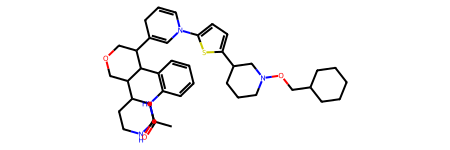

In [86]:
graph_to_mol(trial.ctx, graphs[traj_id][-1])

In [87]:
mols = []
valid = []

for t in graphs:
    cur_traj = []
    cur_val = []
    last_val = None
    for g in t[1:]:
        try:
            cur_mol = graph_to_mol(trial.ctx, g)
            cur_traj.append(cur_mol)
            cur_val.append(True)
            last_val = cur_mol
        except:
            cur_val.append(False)
            cur_traj.append(last_val)
    mols.append(cur_traj)
    valid.append(cur_val)

### Check validity of molecules on given step

In [88]:
df_valid = pd.DataFrame(valid)

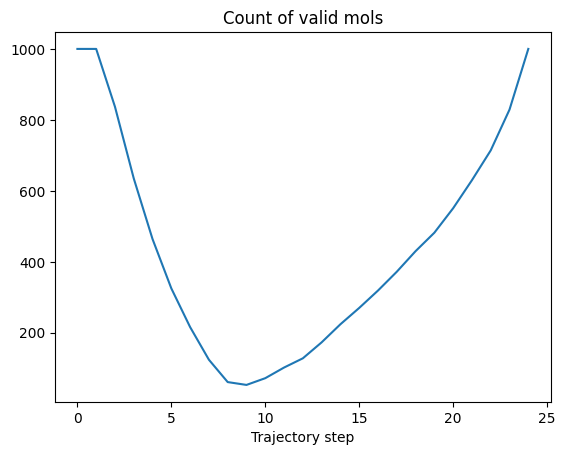

In [89]:
plt.plot(range(len(df_valid.columns)), df_valid.sum())
plt.title("Count of valid mols")
plt.xlabel("Trajectory step")
plt.show()

### Basic graph properties

In [90]:
# Here we can see what attributes are required for each node
graphs[0][-1].edges(data=True)

EdgeDataView([(0, 1, {'src_attach': 0, 'dst_attach': 5}), (0, 3, {'src_attach': 4, 'dst_attach': 1}), (0, 4, {'src_attach': 1, 'dst_attach': 0}), (1, 2, {'src_attach': 0, 'dst_attach': 2}), (2, 5, {'src_attach': 0, 'dst_attach': 1}), (3, 8, {'src_attach': 0, 'dst_attach': 0}), (5, 6, {'src_attach': 0, 'dst_attach': 1}), (6, 7, {'dst_attach': 4, 'src_attach': 0})])

In [91]:
num_edges = []
num_nodes = []
valid_edges = []
for t in graphs:
    e = []
    n = []
    val_e = []
    for g in t:
        n.append(g.number_of_nodes())
        e.append(g.number_of_edges())
        e_cnt = 0
        for u, v, a in g.edges(data=True):
            if ('dst_attach' in list(a.keys())) & ('src_attach' in list(a.keys())):
                e_cnt += 1
        val_e.append(e_cnt)
    valid_edges.append(val_e)
    num_edges.append(e)
    num_nodes.append(n)

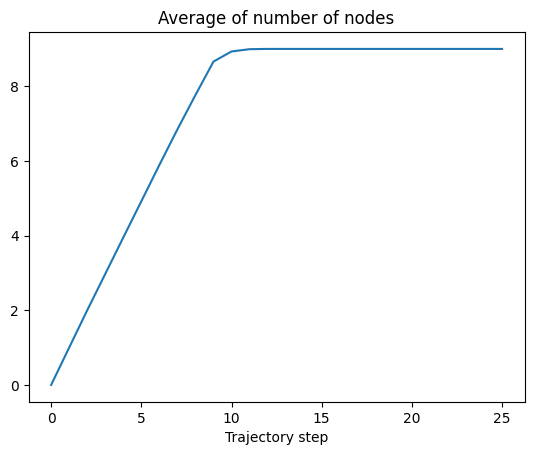

In [92]:
df_nodes = pd.DataFrame(num_nodes)
plt.plot(range(len(df_nodes.columns)), df_nodes.mean())
plt.title("Average of number of nodes")
plt.xlabel("Trajectory step")
plt.show()

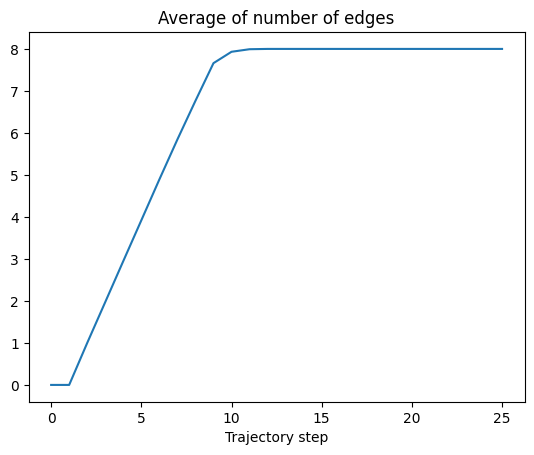

In [93]:
df_edges = pd.DataFrame(num_edges)
plt.plot(range(len(df_edges.columns)), df_edges.mean())
plt.title("Average of number of edges")
plt.xlabel("Trajectory step")
plt.show()

In [94]:
for id, t in enumerate(valid_edges):
    total_edges = t[-1]
    valid_edges[id] = [x/total_edges for x in t]

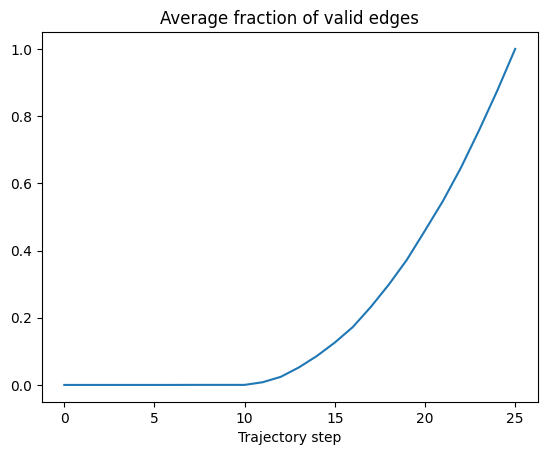

In [95]:
df_val_edges = pd.DataFrame(valid_edges)
plt.plot(range(len(df_val_edges.columns)), df_val_edges.mean())
plt.title("Average fraction of valid edges")
plt.xlabel("Trajectory step")
plt.show()

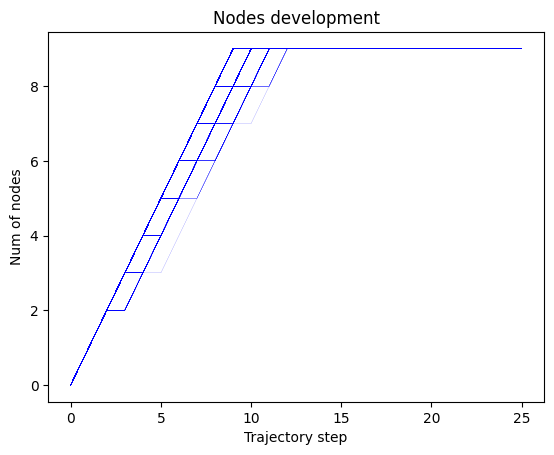

In [96]:
for t in num_nodes:
    plt.plot(range(len(t)), t, color="blue", linewidth=0.1)
plt.title("Nodes development")
plt.xlabel("Trajectory step")
plt.ylabel("Num of nodes")
plt.show()

### Chemical features

In [97]:
# Chem featurizer
feat = dc.feat.RDKitDescriptors()

In [98]:
arr = feat.featurize(mols[traj_id])

In [99]:
pd.DataFrame(arr, columns=feat.descriptors)

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,SPS
0,2.923611,2.923611,1.076389,1.076389,0.458520,17.333333,81.118,74.062,81.057849,32.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.333333
1,5.324875,5.324875,0.760370,0.760370,0.639424,24.833333,165.236,150.116,165.115364,66.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.833333
2,5.324875,5.324875,0.760370,0.760370,0.639424,24.833333,165.236,150.116,165.115364,66.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.833333
3,5.324875,5.324875,0.760370,0.760370,0.639424,24.833333,165.236,150.116,165.115364,66.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.833333
4,5.324875,5.324875,0.760370,0.760370,0.639424,24.833333,165.236,150.116,165.115364,66.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.833333
5,5.324875,5.324875,0.760370,0.760370,0.639424,24.833333,165.236,150.116,165.115364,66.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.833333
6,5.324875,5.324875,0.760370,0.760370,0.639424,24.833333,165.236,150.116,165.115364,66.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.833333
7,5.324875,5.324875,0.760370,0.760370,0.639424,24.833333,165.236,150.116,165.115364,66.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.833333
8,5.324875,5.324875,0.760370,0.760370,0.639424,24.833333,165.236,150.116,165.115364,66.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.833333
9,5.324875,5.324875,0.760370,0.760370,0.639424,24.833333,165.236,150.116,165.115364,66.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.833333


In [100]:
# Featurize data
num_actions = []
for m in mols:
    num_actions.append(feat.featurize(m).tolist())

In [112]:
flat_X = []
flat_y = []
for id, t in enumerate(num_actions):
    actions = traj[id]
    for idx, a in enumerate(t):
        flat_X.append(a)
        flat_y.append(actions[idx][1].action.cname)

In [136]:
df_flat_ = pd.DataFrame(flat_X, columns=feat.descriptors)
df_flat_["target"] = flat_y
print(df_flat_.size)

5300000


In [140]:
df_flat = df_flat_.drop_duplicates()
print(df_flat.size)

1573888


### Action classifier

In [133]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier

In [142]:
X, y = df_flat[[col for col in df_flat.columns if col != "target"]], df_flat["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [144]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [145]:
rf.score(X_test, y_test)

0.773063973063973

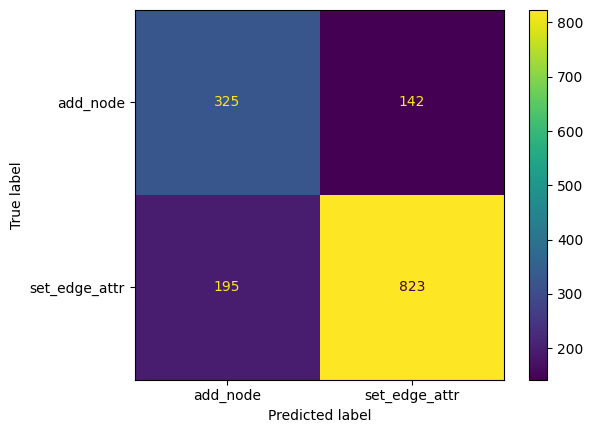

In [146]:
predictions = rf.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot()
plt.show()

In [161]:
sort_perm = np.argsort(rf.feature_importances_)
most_important = rf.feature_importances_[sort_perm][::-1]
most_important_names = rf.feature_names_in_[sort_perm][::-1]

<Axes: >

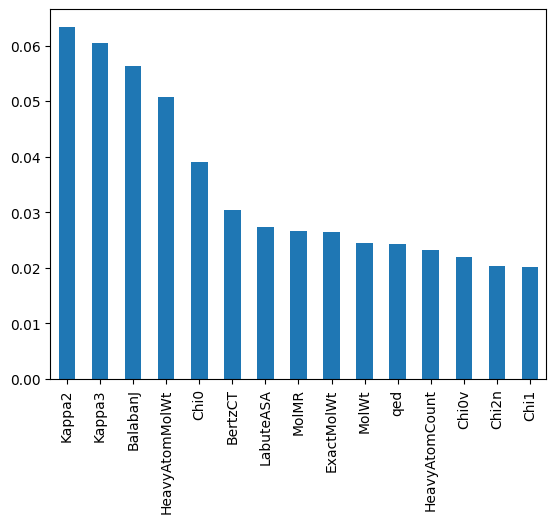

In [164]:
forest_importances = pd.Series(most_important[:15], index=most_important_names[:15])
forest_importances.plot.bar()

### Trajectories embeddings

In [167]:
from keras import metrics
import keras
import tensorflow as tf

In [303]:
def build_net(seq_len=25, feats=4):
    model = keras.Sequential()
    model.add(keras.layers.LSTM(32, kernel_initializer='he_uniform', batch_input_shape=(None, seq_len, feats), return_sequences=True, name='encoder_1'))
    model.add(keras.layers.LSTM(16, kernel_initializer='he_uniform', return_sequences=True, name='encoder_2'))
    model.add(keras.layers.LSTM(8, kernel_initializer='he_uniform', return_sequences=False, name='encoder_3'))
    model.add(keras.layers.RepeatVector(seq_len, name='encoder_decoder_bridge'))
    model.add(keras.layers.LSTM(8, kernel_initializer='he_uniform', return_sequences=True, name='decoder_1'))
    model.add(keras.layers.LSTM(16, kernel_initializer='he_uniform', return_sequences=True, name='decoder_2'))
    model.add(keras.layers.LSTM(32, kernel_initializer='he_uniform', return_sequences=True, name='decoder_3'))
    model.add(keras.layers.TimeDistributed(keras.layers.Dense(feats)))
    return model


In [304]:
X, X_val = train_test_split(num_actions, test_size=0.2)

In [305]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=1e-3, patience=5, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True)

opt = keras.optimizers.Adam(learning_rate=0.1)
emb_nn = build_net(feats=len(feat.descriptors))
emb_nn.compile(loss="mse",optimizer=opt)
emb_nn.build()

epochs = 500
batch_size = 64
hist = emb_nn.fit(x=X, y=X, validation_data=(X_val, X_val), epochs=epochs, batch_size=batch_size, shuffle=True, callbacks=[early_stop])

Epoch 1/500
13/13 [==============================] - 20s 808ms/step - loss: 6593.8066 - val_loss: 6299.6133
Epoch 2/500
13/13 [==============================] - 0s 21ms/step - loss: 5939.2173 - val_loss: 5615.9473
Epoch 3/500
13/13 [==============================] - 0s 21ms/step - loss: 5301.4556 - val_loss: 5015.1113
Epoch 4/500
13/13 [==============================] - 0s 21ms/step - loss: 4768.2939 - val_loss: 4513.9429
Epoch 5/500
13/13 [==============================] - 0s 21ms/step - loss: 4316.3999 - val_loss: 4101.1816
Epoch 6/500
13/13 [==============================] - 0s 21ms/step - loss: 3948.2529 - val_loss: 3741.6028
Epoch 7/500
13/13 [==============================] - 0s 22ms/step - loss: 3615.7646 - val_loss: 3399.1270
Epoch 8/500
13/13 [==============================] - 0s 29ms/step - loss: 3281.6169 - val_loss: 3054.4797
Epoch 9/500
13/13 [==============================] - 0s 30ms/step - loss: 2974.6907 - val_loss: 2767.4978
Epoch 10/500
13/13 [========================

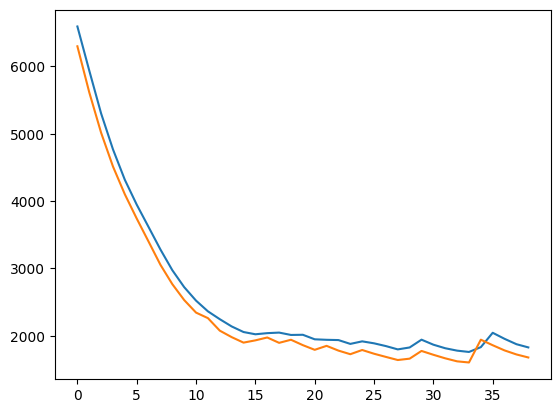

In [306]:
plt.plot(range(len(hist.history["loss"])), hist.history["loss"])
plt.plot(range(len(hist.history["val_loss"])), hist.history["val_loss"])
plt.show()

In [307]:
from keras.models import Model
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [308]:
encoder = Model(emb_nn.input, emb_nn.layers[2].output)

In [309]:
embeddings = encoder.predict(num_actions)

32/32 [==============================] - 1s 5ms/step


In [310]:
enb_reduce = TSNE(n_components=2).fit_transform(embeddings)

In [311]:
enb_reduce.shape

(1000, 2)

In [312]:
sum(np.array(rew)>6.5)

56

In [313]:
def plt_reduce_space(x, color=rew):
    '''
    Plot Scatter with color
    '''
    plt.figure(figsize=(8, 8))
    plt.scatter(x[:, 0], x[:, 1], c=color, cmap='coolwarm')
    plt.show()

In [314]:
def plt_best(x, rew, t=6.5):
    '''
    Plot Scatter with color
    '''
    filter = np.array(rew)>t
    plt.figure(figsize=(8, 8))
    plt.scatter(x[~filter, 0], x[~filter, 1], c="lightblue")
    plt.scatter(x[filter, 0], x[filter, 1], c="red")
    plt.show()

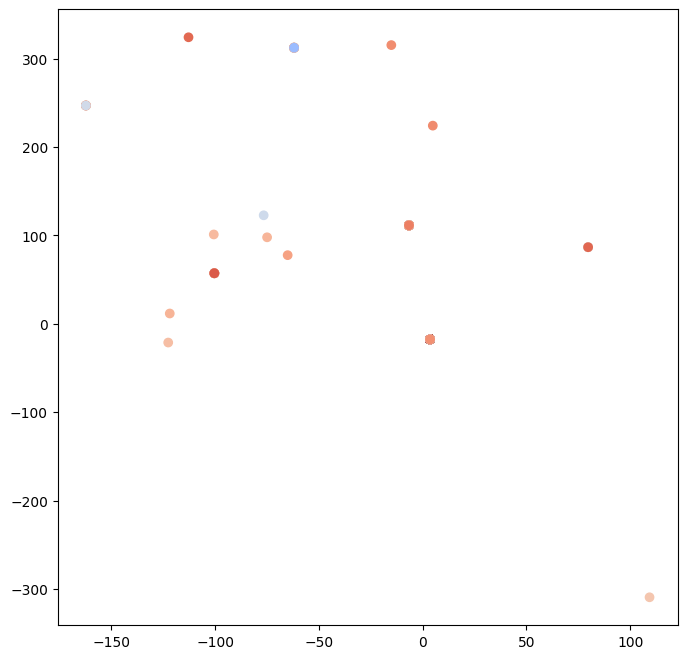

In [315]:
plt_reduce_space(enb_reduce)

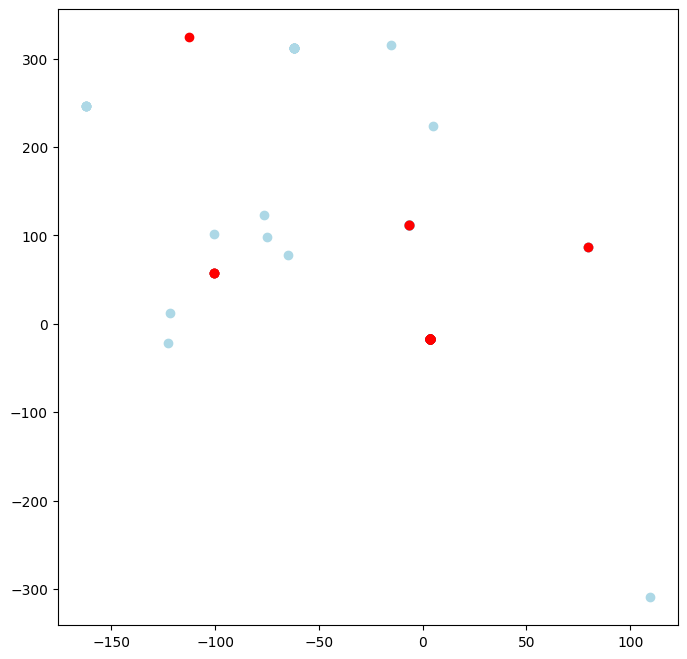

In [316]:
plt_best(enb_reduce, rew)

In [320]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=12)
km.fit(enb_reduce)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=12)

In [321]:
df_cluster = pd.DataFrame(enb_reduce)
df_cluster["label"] = km.labels_
df_cluster["reward"] = rew

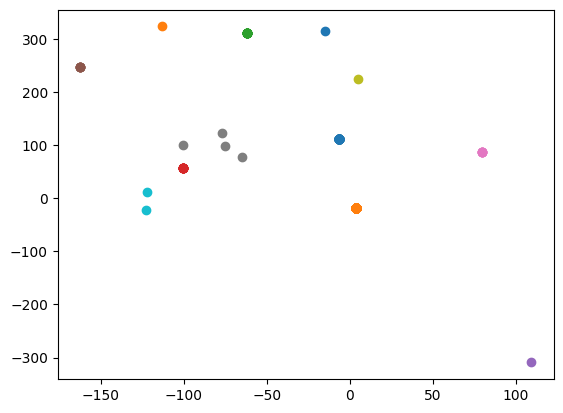

In [322]:
for l in np.unique(km.labels_):
    plt.scatter(df_cluster[df_cluster["label"] == l].iloc[:, 0], df_cluster[df_cluster["label"] == l].iloc[:, 1], label = l)
plt.show()

In [323]:
df_cluster.groupby("label").count()

,0,1,reward
label,,,
0,70,70,70
1,885,885,885
2,15,15,15
3,10,10,10
4,1,1,1
5,5,5,5
6,5,5,5
7,4,4,4
8,1,1,1


In [301]:
df_cluster.groupby("label").mean("reward")

,0,1,reward
label,,,
0,252.483551,-18.330450,5.040743
1,74.904922,105.160423,5.124342
2,179.189499,36.089088,5.080852
3,126.713135,234.708694,4.452455
4,166.221664,-13.448226,5.046844
5,182.625900,138.388443,5.818920
6,241.245621,69.476471,5.377553
7,170.078125,-52.034500,5.566677
8,151.290176,-26.536985,3.496760


In [203]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.3, min_samples=10).fit(embeddings)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 1
Estimated number of noise points: 0


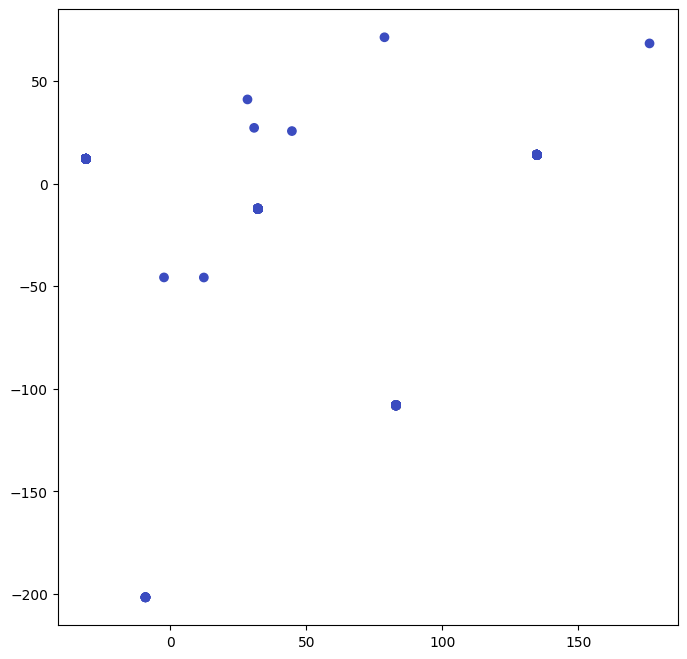

In [204]:
plt_reduce_space(enb_reduce, color=labels)